# 데이터셋 불러오기

In [1]:
from tensorflow.keras.datasets import mnist
(train_images, _), (test_images, _) = mnist.load_data()

In [2]:
train_images.dtype

dtype('uint8')

In [3]:
train_images = (test_images.astype('float32') - 127.5) / 127.5 # -1~1 사이로 표준화
print(train_images.dtype)

float32


In [4]:
import numpy as np
train_images = np.expand_dims(train_images, axis=-1)
print(train_images.shape) # channel last 이미지 데이터

(10000, 28, 28, 1)


# generator, discriminator 모델 정의

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# 생성자
generator_model = Sequential([
    layers.Input(shape=(100,)), # 입력 노이즈의 shape(크기)
    layers.Dense(7*7*256, use_bias=False, activation='elu'),
    layers.BatchNormalization(),

    layers.Reshape((7,7,256)),
    layers.Conv2DTranspose(128, (5,5), padding='same', activation='elu'), # 7x7x128
    # layers.Conv2D(128, 5, padding='same', activation='elu')
    layers.BatchNormalization(),

    layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', activation='elu'), # 14x14x64
    layers.BatchNormalization(),

    layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', activation='tanh') # 28x28x1 데이터
])
generator_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819328    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                                
                                                        

In [6]:
# 판별자
discriminator_model = Sequential([
    layers.Input(shape=(28,28,1)),
    layers.Conv2D(64, (5,5), strides=(2,2), padding='same', activation='elu'),
    layers.Dropout(0.3),

    layers.Conv2D(128, (5,5), strides=(2,2), padding='same', activation='elu'),
    # layers.Conv2D(128, (5,5), padding='same', activation='elu'),
    layers.Dropout(0.3),
    # layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(1)
])
discriminator_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212865 (831.50 KB)
Trainable params: 212

# 손실함수와 옵티마이저 정의

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()

# 배치 데이터 준비

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(256)
print(train_dataset)

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


In [9]:
for batch in train_dataset:
    print(".", end="")
# print(train_dataset.batch)

........................................

# 학습(훈련)을 정의

In [10]:
def train_step(images):
    noise = tf.random.normal([256, 100]) # 이미지 생성을 위한 노이즈 입력
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape: # 미분을 위한 도구, loss를 계산
        # loss를 계산하려면 모델, 손실함수, 입력값 X와 y, 파라미터가 있어야 합니다.
        generated_image = generator_model(noise, training=True)
        fake_output = discriminator_model(generated_image, training=True)
        real_output = discriminator_model(images, training=True)

        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
    gradients_of_discriminator = dis_tape.gradient(dis_loss, discriminator_model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))


In [11]:
L1 = [1,2,3]
L2 = [4,5,6]
list(zip(L1, L2))

[(1, 4), (2, 5), (3, 6)]

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.30it/s]


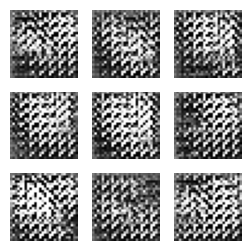

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.30it/s]


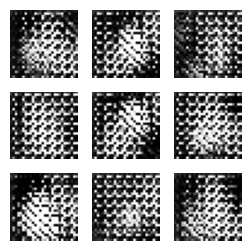

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.31it/s]


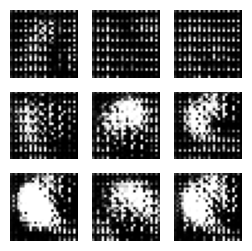

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.31it/s]


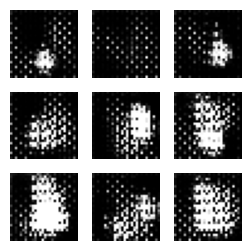

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.29it/s]


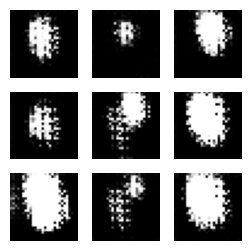

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.27it/s]


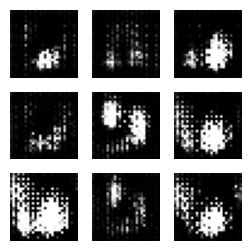

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.26it/s]


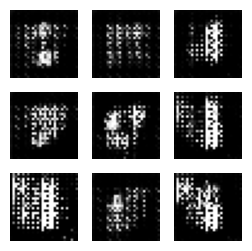

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.28it/s]


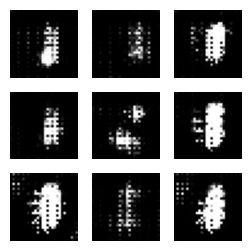

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.26it/s]


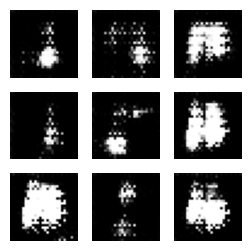

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.27it/s]


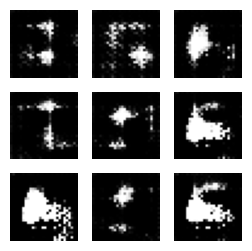

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.29it/s]


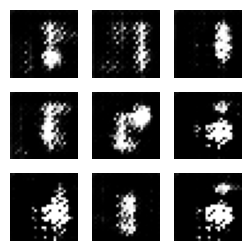

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.27it/s]


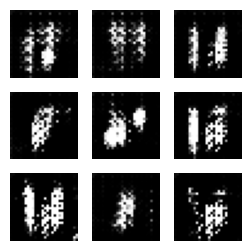

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.26it/s]


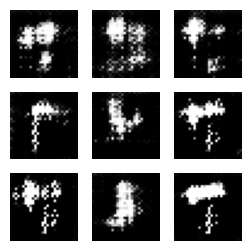

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.21it/s]


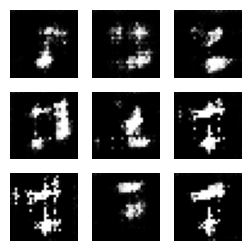

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.23it/s]


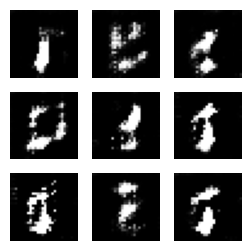

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.26it/s]


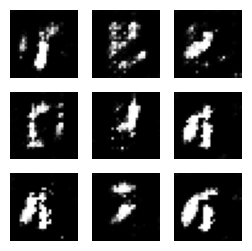

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.27it/s]


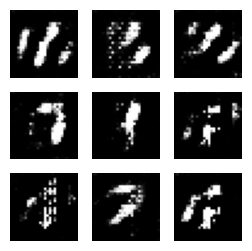

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.27it/s]


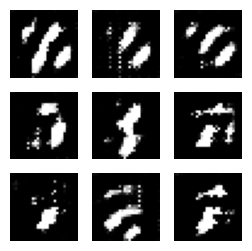

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.26it/s]


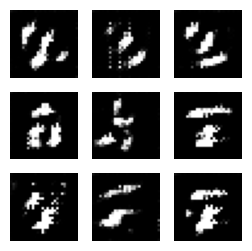

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.25it/s]


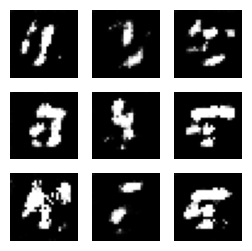

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.26it/s]


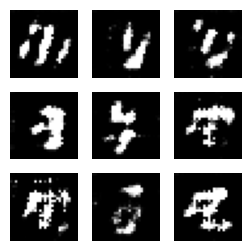

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.25it/s]


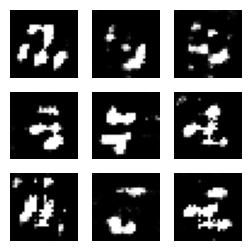

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.24it/s]


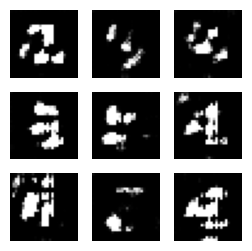

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.25it/s]


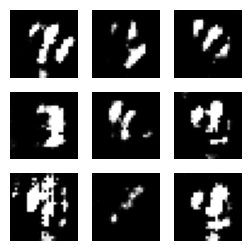

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.25it/s]


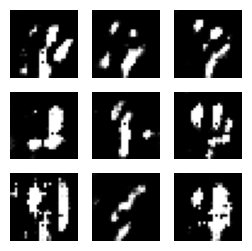

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


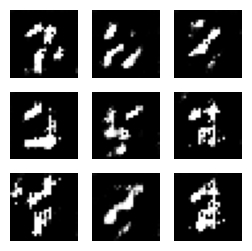

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.24it/s]


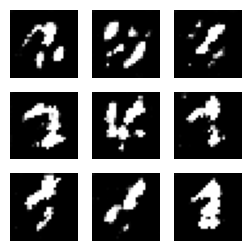

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.27it/s]


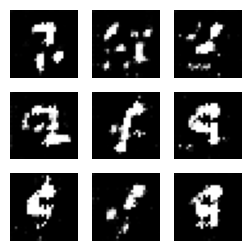

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.21it/s]


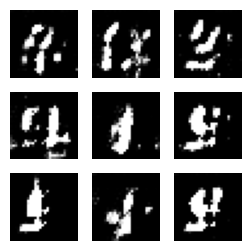

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.19it/s]


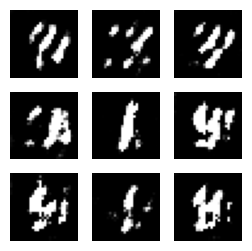

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:34<00:00,  1.17it/s]


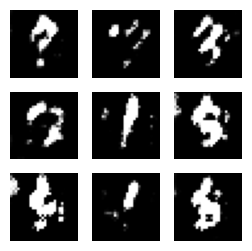

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.23it/s]


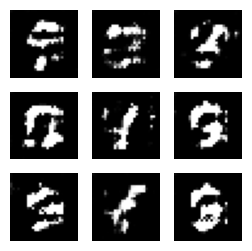

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.20it/s]


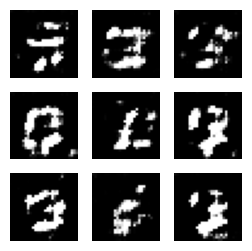

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:34<00:00,  1.17it/s]


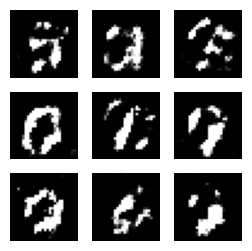

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


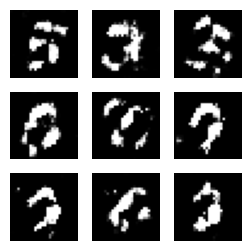

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


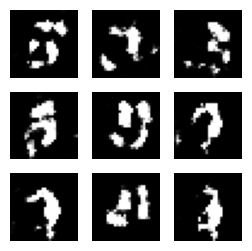

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.24it/s]


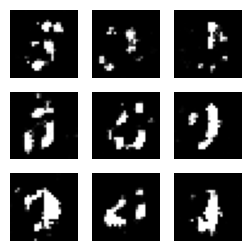

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.23it/s]


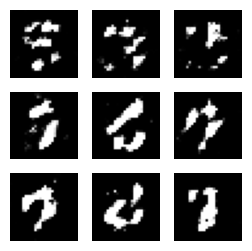

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.21it/s]


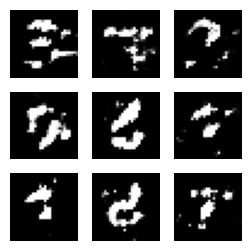

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.26it/s]


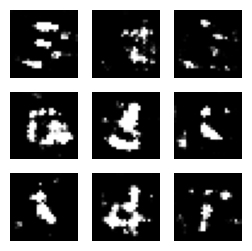

 22%|██████████████████▋                                                                | 9/40 [00:06<00:23,  1.33it/s]

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm # 반복문 실행상태 표시기
sample_seed = tf.random.normal([9, 100]) # 9개 샘플 이미지를 만들기 위한 노이즈

for epoch in range(100):
    for image_batch in tqdm(train_dataset):
        train_step(image_batch)
        # print('.', end='')
    # print(f'{epoch+1}')

    # 훈련과정을 보여주기 위한 코드입니다.
    sample_image = generator_model(sample_seed, training=False) # 매 학습 후 이미지를 생성합니다.
    
    plt.figure(figsize=(3,3)) # 도화지 크기를 가로세로 5인치 크기로 설정.
    for i in range(sample_image.shape[0]): # 9개 이미지
        plt.subplot(3,3, i+1) # 3행 3열로 나눈 도화지 영역의 i+1 번째에 그림을 그리겠습니다.
        plt.imshow(sample_image[i, :, :, 0]*0.5 + 0.5, cmap='gray')
        plt.axis('off')
    # plt에 그려진 이미지를 파일에 저장
    plt.savefig(f'epoch-{epoch:04d}.png')
    plt.show()